In [1]:
import os
import re
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

### Activate interactive plotting
**qt ->** figures opened in windows outside the notebook

**notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
# data_path = base_path + "second_batch/originals/"
data_path = base_path + "second_batch/bigger_diam/"
s2p_path = data_path + "s2p/"

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = io.imread(os.path.join(base_path, "noise_stimulus.tif"))
raw_noise = raw_noise.transpose(0, 2, 1) / 255
print("raw noise shape:", raw_noise.shape)
zoom_noise = simple_upsample_2D(raw_noise, 16, 16)
print("zoom noise shape:", zoom_noise.shape)
# 60Hz for 60s after 10s delay
noise_xaxis = np.arange(3600) * (1 / 60) + 10.

raw noise shape: (3600, 16, 16)
zoom noise shape: (3600, 256, 256)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackPlotter`).

<IPython.core.display.Javascript object>


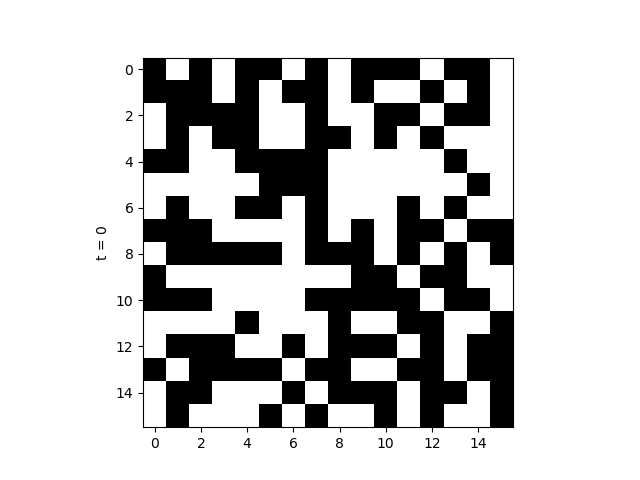

In [5]:
raw_noise_stack_fig, raw_noise_stack_ax = plt.subplots(1)
raw_noise_stack = StackPlotter(
    raw_noise_stack_fig,
    raw_noise_stack_ax,
    raw_noise, delta=10
)
raw_noise_stack_fig.show()

Show "zoomed" / scaled up version of noise stack, should look the same as above (feel free to comment out, just here as a reference).

In [6]:
# zoom_noise_stack_fig, zoom_noise_stack_ax = plt.subplots(1)
# zoom_noise_stack = StackPlotter(
#     zoom_noise_stack_fig,
#     zoom_noise_stack_ax,
#     zoom_noise
# )
# zoom_noise_stack_fig.show()

### Example of signal over time of a particular pixel in the noise stimulus

<IPython.core.display.Javascript object>


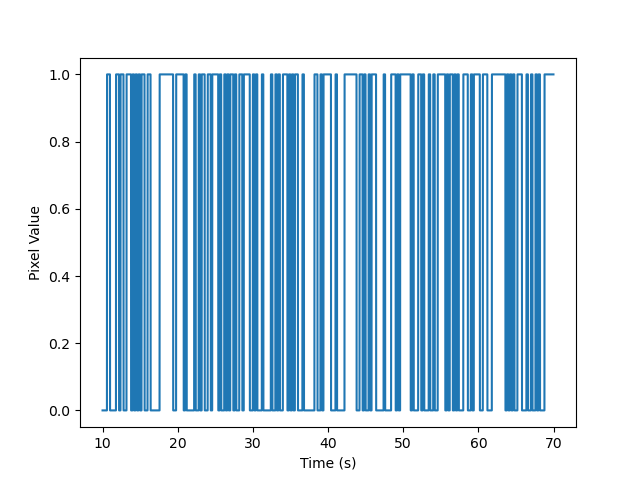

In [7]:
noise_beam_fig, noise_beam_ax = plt.subplots(1)
noise_beam_ax.plot(noise_xaxis, raw_noise[:, 0, 0])
noise_beam_ax.set_xlabel("Time (s)")
noise_beam_ax.set_ylabel("Pixel Value")
noise_beam_fig.show()

### List tiff files found in the directory indicated by `data_path`

#### Note:
**DD ->** distal. **X** 71.7um, **Y** 28.94um

**PD ->** proximal. **X** 71.7um, **Y** 30.9um

In [8]:
fnames = [
    f for f in os.listdir(data_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:
  scan14_00051_DD_ch1_400um.tif
  scan14_00051_PD_ch1_400um.tif
  scan14_00055_DD_ch1_200um.tif
  scan14_00055_PD_ch1_200um.tif
  scan9_00035_DD_ch1_400um.tif
  scan9_00035_PD_ch1_400um.tif
  scan9_00040_DD_ch1_200um.tif
  scan9_00040_PD_ch1_200um.tif


### Select (and display) recording to analyse here.
Set `ex_name` to the name shared by the desired `.tif` (found in `data_path`) and the `.h5` (found in `s2p_path`). Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackPlotter`).

Recording shape: (1700, 256, 256)


<IPython.core.display.Javascript object>


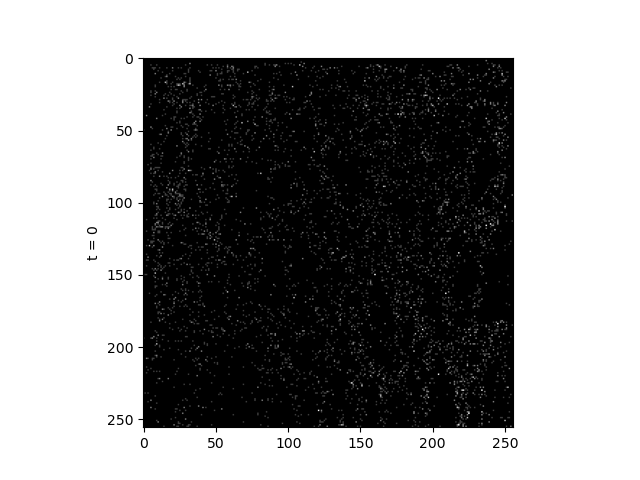

In [9]:
ex_name = "scan14_00051_DD_ch1_400um"
ex_stack = io.imread(os.path.join(data_path, ex_name + ".tif"))
with h5.File(os.path.join(s2p_path, ex_name + ".h5"), "r") as f:
    ex_s2p = unpack_hdf(f)

print("Recording shape:", ex_stack.shape)
    
ex_stack_fig, ex_stack_ax = plt.subplots(1)
ex_stack_plot = StackPlotter(
    ex_stack_fig,
    ex_stack_ax,
    ex_stack,
    delta=10
)
ex_stack_fig.show()

### Pixel map ROIs generated by suite2p
Use scroll wheel to cycle through ROIs. Gridlines correspond to the noise stimulus.

<IPython.core.display.Javascript object>


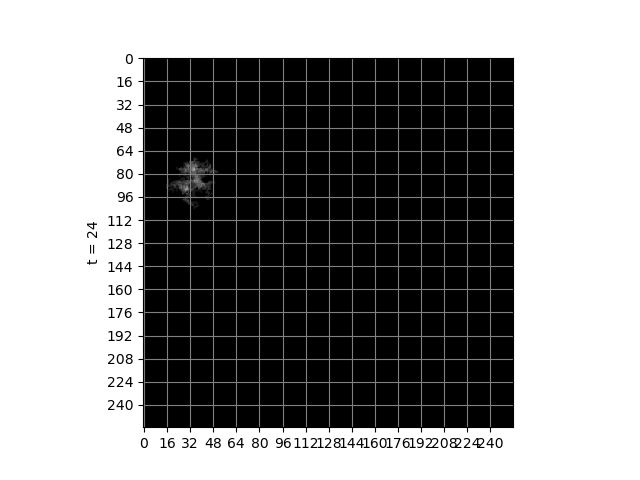

In [10]:
mask_stack = ex_s2p["masks"].transpose(2, 0, 1)
mask_stack_fig, mask_stack_ax = plt.subplots(1)
mask_stack_plot = StackPlotter(
    mask_stack_fig,
    mask_stack_ax,
    mask_stack,
    delta=1
)

# gridlines corresponding to noise stimulus
loc = plticker.MultipleLocator(base=16)
mask_stack_ax.xaxis.set_major_locator(loc)
mask_stack_ax.yaxis.set_major_locator(loc)
mask_stack_ax.grid(which='major', axis='both', linestyle='-', c="grey")
mask_stack_fig.show()

### Denoise and signal-noise normalize ROI responses

In [11]:
recs = ex_s2p["recs"] - ex_s2p["Fneu"] * 0.7
recs_xaxis = np.arange(1700) * 0.05  # 20Hz sampling rate

# normalize to noise and remove offset
recs /= np.var(recs[:, :198], axis=1).reshape(-1, 1)
recs -= np.mean(recs[:, :198], axis=1).reshape(-1, 1)

def moving_avg(arr, width):
    return np.convolve(arr, np.ones(width) / width, "same")

# filtered = np.stack([butter_bandpass_filter(roi, 0.0001, 1, 10) for roi in recs], axis=0)
filtered = np.stack([signal.savgol_filter(roi, 9, 2) for roi in recs], axis=0)
# filtered = np.stack([moving_avg(roi, 7) for roi in recs], axis=0)

### Display raw and filtered responses for ROIs
Use scroll wheel over the figure to cycle through ROIs. Threshold for highlighted events can be set with `thresh` variable. This just provides a visual, and does not impact further analysis later on.

<IPython.core.display.Javascript object>


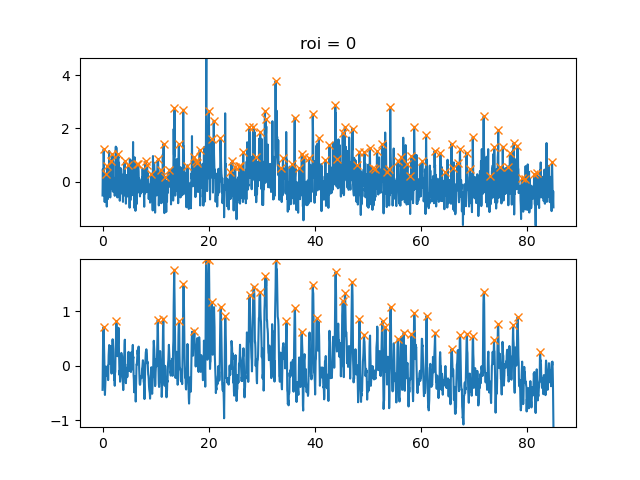

In [120]:
# TODO: should filter out the ROIs that do not meet a certain
# signal to noise criteria, right now, many are duds.

beam_idx = 0  # here to be manipulated by beams_onscroll, leave as is
n_beams = recs.shape[0]
thresh = 1  # threshold for events (to be highlighted with crosses)
min_peak_interval = 1

raw_peaks, _ = signal.find_peaks(recs[beam_idx], height=thresh)
filt_peaks, _ = signal.find_peaks(filtered[beam_idx], height=thresh)
beams_fig, beams_ax = plt.subplots(2)
lines = [
    [
        beams_ax[0].plot(recs_xaxis, recs[beam_idx]),
        beams_ax[0].plot(recs_xaxis[raw_peaks], recs[beam_idx, raw_peaks], "x"),
    ],
    [ 
        beams_ax[1].plot(recs_xaxis, filtered[beam_idx]),
        beams_ax[1].plot(recs_xaxis[filt_peaks], filtered[beam_idx, filt_peaks], "x"),
    ]
]

beams_ax[0].set_ylim(recs.min(), recs.max())
beams_ax[1].set_ylim(filtered.min(), filtered.max())


def beams_update():
    beams_ax[0].set_title("roi = %i" % beam_idx)
    for ax, ln, data in zip(beams_ax, lines, [recs, filtered]):
        ln[0][0].set_ydata(data[beam_idx])
        peaks, _ = signal.find_peaks(
            data[beam_idx],
#             height=thresh,
            prominence=thresh,
            rel_height=.5,
            width=2,
            distance=min_peak_interval
        )                             
        ln[1][0].set_data(recs_xaxis[peaks], data[beam_idx, peaks])
        ax.set_ylim(data[beam_idx].min(), data[beam_idx].max())
        beams_fig.canvas.draw()
        

def beams_onscroll(event):
    global beam_idx
    if event.button == "up":
        beam_idx = (beam_idx + 1) % n_beams
    else:
        beam_idx = (beam_idx - 1) % n_beams
    beams_update()

beams_fig.canvas.mpl_connect("scroll_event", beams_onscroll)
beams_update()
beams_fig.show()

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `threshold` sets the value which must be passed for `scipy.signal.find_peaks` (currently used by `avg_trigger_window`) to mark an event. Values correspond to those seen in the beam displays above.
- `lead` sets the time (in seconds) to use preceding each threshold passing event.

Also note that the 4th parameter of `avg_trigger_window` is the array of ROI responses used. This could be swapped from `recs` to `filtered` or whatever transformation of the recordings desired, as long as it is of the correct shape (N x Time).

Note that beam pulled from the stimulus movie in this rough implementation is simply all parts of the stimulus grid in which pixels from the cell ROI fall, which is an overestimate of the area of the noise movie that is likely to actually contribute to the response of the bipolar cell in question.

For comparison to the triggered stimulus beam, a randomly triggered beam (using a number of time samples equivalent to the number of "events" used for the triggered one) is also generated and displayed. This will be different each time this cell is run. This is to give a sense of how variable the average is, based on the amount of data (time and frequency of threshold passing responses) that we are working with.

<IPython.core.display.Javascript object>


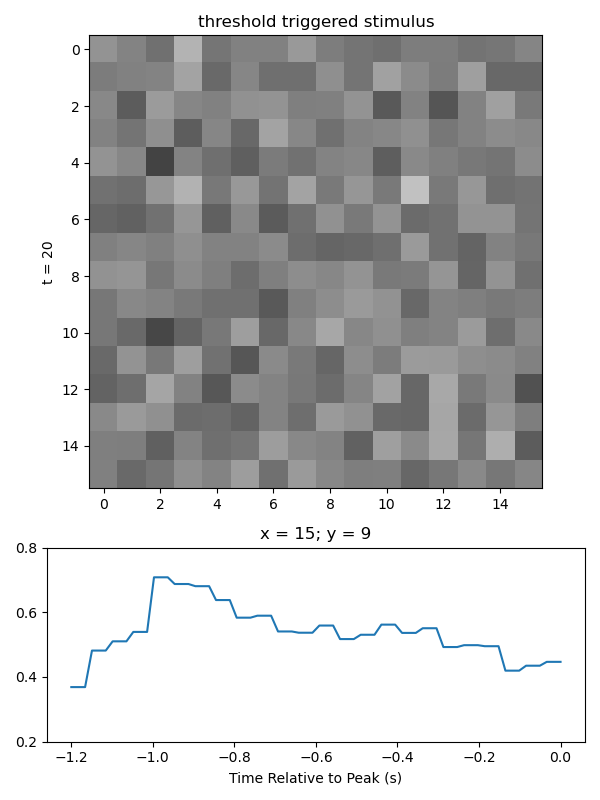

In [122]:
roi_idx = 24
threshold = 1.
peak_width = 2
peak_tolerance = .5
min_peak_interval = 1
lead = 1.2


peak_idxs, peak_props = signal.find_peaks(
    recs[roi_idx],
    prominence=threshold,
    width=peak_width,
    rel_height=peak_tolerance,
    distance=min_peak_interval
)

lead_stack = avg_trigger_window(
    noise_xaxis, 
    raw_noise,
    recs_xaxis,
    recs[roi_idx],
    lead,
    peak_idxs,
    prominences=peak_props["prominences"],
)

lead_xaxis = np.linspace(
    lead_stack.shape[0] * (-1 / 60), 
    0, 
    lead_stack.shape[0],
)

lead_stack_fig, lead_stack_ax = plt.subplots(
    2,
    figsize=(6, 8),
    gridspec_kw={"height_ratios": [.7, .3]}
)
lead_stack_plot = StackPlotter(
    lead_stack_fig,
    lead_stack_ax[0],
#     lead_stack,
    reduce_chunks(lead_stack, 3, reducer=np.mean, axis=0),
    delta=1,
    vmin=0,
    vmax=1,
)
lead_stack_ax[0].set_title("threshold triggered stimulus")

line = lead_stack_ax[1].plot(lead_xaxis, lead_stack[:, 0, 0])
lead_stack_ax[1].set_ylim(.2, .8)
lead_stack_ax[1].set_title("x = 0; y = 0")
lead_stack_ax[1].set_xlabel("Time Relative to Peak (s)")
last_x, last_y = 0, 0
def on_move(event):
    global last_x, last_y
    if (
        event.inaxes == lead_stack_ax[0]
        and not (event.xdata is None or event.ydata is None)
    ): 
        x = np.round(event.xdata).astype(np.int)
        y = np.round(event.ydata).astype(np.int)
        if 0 < x < 16 and 0 < y < 16 and (last_x != x or last_y != y):
            last_x, last_y = x, y
            lead_stack_ax[1].set_title("x = %i; y = %i" % (x, y))
            line[0].set_ydata(lead_stack[:, x, y])

lead_stack_fig.canvas.mpl_connect("motion_notify_event", on_move)
lead_stack_fig.tight_layout()

plt.show()

In [118]:
# # example lead window with randomly chosen trigger times
# ts = np.random.uniform(
#     low=(np.min(noise_xaxis) + lead), 
#     high=np.max(noise_xaxis),
#     size=len(peak_idxs)
# )
# random_lead_stack = np.mean([
#     lead_window(noise_xaxis, raw_noise, t, lead) for t in ts
# ], axis=0)

# random_lead_stack_fig, random_lead_stack_ax = plt.subplots(1)
# random_lead_stack_plot = StackPlotter(
#     random_lead_stack_fig,
#     random_lead_stack_ax,
# #     random_lead_stack,
#     reduce_chunks(random_lead_stack, 3, reducer=np.mean, axis=0),
#     delta=1,
#     vmin=0,
#     vmax=1,
# )
# random_lead_stack_ax.set_title("randomly triggered stimulus")

# # example dimensions
# # roi 1 -> [:, :2, 8:13]
# # roi 15 -> [:, 13:, 11:13]

# rough_roi_mask = (
#     measure.block_reduce(mask_stack[roi_idx], (16, 16), np.sum) > 0
# ).astype(np.int)

# rows, cols = np.where(rough_roi_mask)
# lead_beam = np.mean(lead_stack[:, rows, cols], axis=1)
# random_lead_beam = np.mean(random_lead_stack[:, rows, cols], axis=1)
# lead_xaxis = np.linspace(lead_beam.size * (-1 / 60), 0, lead_beam.size)

# lead_beam_fig, lead_beam_ax = plt.subplots(2)
# lead_beam_ax[0].plot(lead_xaxis, lead_beam, label="triggered")
# lead_beam_ax[0].plot(lead_xaxis, random_lead_beam, label="random")
# lead_beam_ax[0].legend()
# lead_beam_ax[1].imshow(rough_roi_mask, cmap="gray")

# var_fig, var_ax = plt.subplots(1)
# var_ax.imshow(np.var(lead_stack, axis=0))

<IPython.core.display.Javascript object>


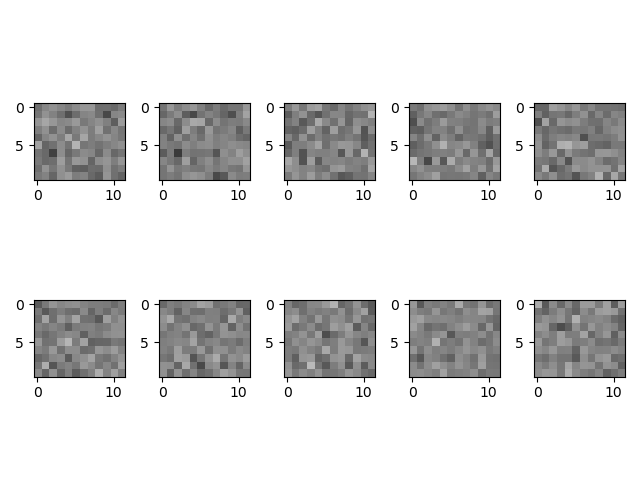

In [42]:
lead_slices_fig, lead_slices_ax = plt.subplots(2, 5)
cropped_lead = lead_stack[:, 3:13, 2:14]
lead_slices_ax[0][0].imshow(np.mean(cropped_lead[-50:-45], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[0][1].imshow(np.mean(cropped_lead[-45:-40], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[0][2].imshow(np.mean(cropped_lead[-40:-35], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[0][3].imshow(np.mean(cropped_lead[-35:-30], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[0][4].imshow(np.mean(cropped_lead[-30:-25], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[1][0].imshow(np.mean(cropped_lead[-25:-20], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[1][1].imshow(np.mean(cropped_lead[-20:-15], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[1][2].imshow(np.mean(cropped_lead[-15:-10], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[1][3].imshow(np.mean(cropped_lead[-10:-5], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_ax[1][4].imshow(np.mean(cropped_lead[-5:], axis=0), vmin=0, vmax=1, cmap="gray")
lead_slices_fig.tight_layout()

In [43]:
# rand_slices_fig, rand_slices_ax = plt.subplots(1, 5)
# cropped_random = random_lead_stack[:, 3:13, 2:14]
# rand_slices_ax[0].imshow(np.mean(cropped_random[-50:-40], axis=0), vmin=0, vmax=1, cmap="gray")
# rand_slices_ax[1].imshow(np.mean(cropped_random[-40:-30], axis=0), vmin=0, vmax=1, cmap="gray")
# rand_slices_ax[2].imshow(np.mean(cropped_random[-30:-20], axis=0), vmin=0, vmax=1, cmap="gray")
# rand_slices_ax[3].imshow(np.mean(cropped_random[-20:-10], axis=0), vmin=0, vmax=1, cmap="gray")
# rand_slices_ax[4].imshow(np.mean(cropped_random[-10:], axis=0), vmin=0, vmax=1, cmap="gray")

In [116]:
# core_beams_fig, core_beams_ax = plt.subplots(1)

# core_beams_ax.plot(lead_stack[:, 7, 6], label="(7, 6)")
# core_beams_ax.plot(lead_stack[:, 8, 6], label="(8, 6)")
# core_beams_ax.plot(lead_stack[:, 7, 7], label="(7, 7)")
# core_beams_ax.plot(lead_stack[:, 8, 7], label="(8, 7)")
# core_beams_ax.plot(lead_stack[:, 7, 8], label="(7, 8)")
# core_beams_ax.plot(lead_stack[:, 8, 8], label="(8, 8)")
# core_beams_ax.plot(lead_stack[:, 7, 9], label="(7, 9)")
# core_beams_ax.plot(lead_stack[:, 8, 9], label="(8, 9)")
# core_beams_ax.legend()

<IPython.core.display.Javascript object>


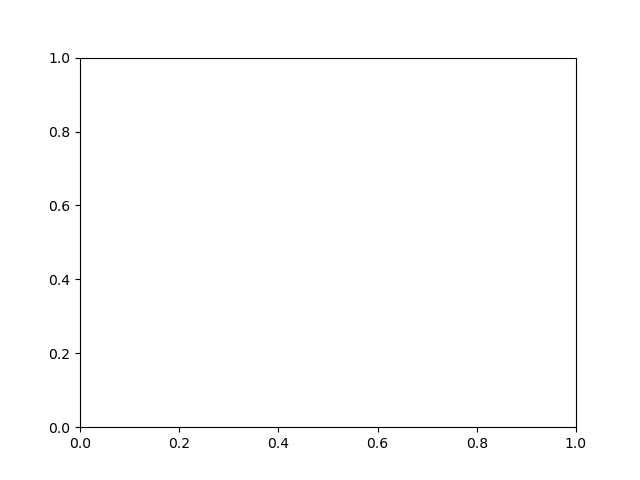

In [117]:
misc_beams_fig, misc_beams_ax = plt.subplots(1)

# ROI 24 ("scan14_00051_DD_ch1_400um")
# misc_beams_ax.plot(lead_stack[:, 7, 5])
# misc_beams_ax.plot(lead_stack[:, 7, 6])
# misc_beams_ax.plot(lead_stack[:, 8, 5])
# misc_beams_ax.plot(lead_stack[:, 8, 6])
# misc_beams_ax.plot(np.mean(lead_stack[:, 7:9, 5:7], axis=(1,2)))

# ROI 11
# misc_beams_ax.plot(lead_stack[:, 9, 12])
# misc_beams_ax.plot(lead_stack[:, 10, 11])
# misc_beams_ax.plot(lead_stack[:, 11, 13])
# misc_beams_ax.plot(np.mean(lead_stack[:, 7:9, 11], axis=1))
# misc_beams_ax.plot(np.mean(lead_stack[:, 7:9, 15], axis=1)) # surround?

In [17]:
# X 71.7um, Y 28.94um
print(256 / 71.7)
print(256 / 28.94)
print(16 / 400)

3.5704323570432357
8.84588804422944
0.04


### Comparison of recording stack scale to noise stimulus.

<IPython.core.display.Javascript object>


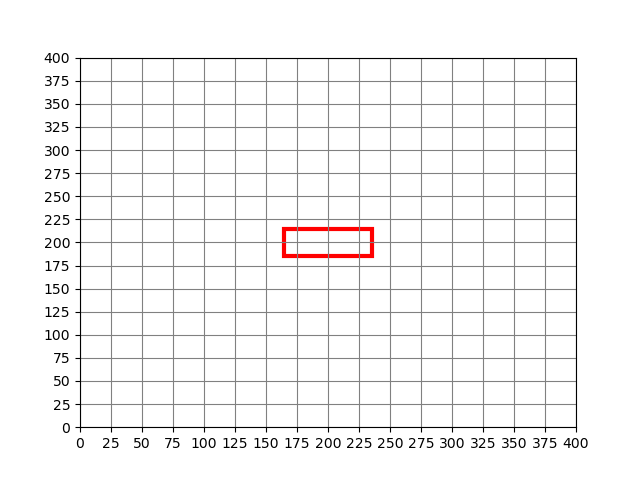

In [18]:
stim_width = 400
stim_height = 400
rec_width = 71.7
rec_height = 28.94
x_corner = (stim_width - rec_width) / 2
y_corner = (stim_height - rec_height) / 2

dims_fig, dims_ax = plt.subplots(1)
dims_ax.set_ylim(0, stim_height)
dims_ax.set_xlim(0, stim_width)
field = Rectangle(
    (x_corner, y_corner),
    rec_width, 
    rec_height,
    fill=False,
    color="red",
    linewidth=3,
)
dims_ax.add_patch(field)

x_loc = plticker.MultipleLocator(base=(stim_width / 16))
y_loc = plticker.MultipleLocator(base=(stim_height / 16))
dims_ax.xaxis.set_major_locator(x_loc)
dims_ax.yaxis.set_major_locator(y_loc)
dims_ax.grid(which='major', axis='both', linestyle='-', c="grey")

90